# Effect of statistical uncertainty

Probability distributions of load variables are typically based on limited data, leading to (statistical) uncertainty in the estimates of loads for given exceedance probabilities.

Let's consider a load variable $X$ and a random variable $V$, which represents the associated statistical uncertainty. The probability $P(X>x)$ is known, as well as the probability distribution of $V$. Now, let's define a new variable 
$X_{incl}$ as $X+V$. The goal is to estimate $P(X_{incl}>x)$.

In this example, we will demonstrate how to calculate the effect of statistical uncertainty on the exceedance probability of river discharge.

First, let's import the necessary packages:

In [2]:
from probabilistic_library import ReliabilityProject, DistributionType, ReliabilityMethod, FragilityValue, ConditionalValue, StandardNormal
import matplotlib.pyplot as plt

We consider the following limit state function:

$Z = w - (Q +V)$

where: <br>

$Q$ is the river discharge, without the statistical uncertainty (m3/s) <br>
$V$ is the statistical uncertainty (m3/s) <br>
$w$ represents a specific value of the river discharge (m3/s)

The river discharge $Q$ is represented as an empirical cumulative distribution function (CDF). The exceedance probabilities of the river discharge for different stages are defined as follows:

In [3]:
Q_value = [5940,7970,9130,10910,12770,14000,14840,14970,15520,16270,16960,17710]
Pf_no_stat_uncer = [0.083333333,0.033333333,0.016666667,0.005555556,0.001666667,0.000555556,0.000166667,0.000133333,5.55556E-05,1.66667E-05,5.55556E-06,1.66667E-06]

The statistical uncertainty $V$ is normally distributed with a mean of 0. The standard deviation $σ$ is a function of $Q$, defined as follows:

In [4]:
V_q_value = [5939.9,5940,7970,9130,10910,12770,14000,14840,14970,15520,16270,16960,17710]
sigma = [340,340,440,500,600,700,560,620,640,750,930,1120,1350]

We define the limit state function:

In [5]:
def limit_state_function(q, v, w):
    return w - (q + v)

To perform a reliability analysis, we create a reliability project and specify the limit state function (model):

In [6]:
project = ReliabilityProject()
project.model = limit_state_function

Now we define the stochastic variables, starting with the discharge $Q$. We represent this variable as `cdf_curve`. In this case, it is needed to define the `FragilityValue` object and specify its attributes `x` and `probability_of_failure`.

In [7]:
project.variables["q"].distribution = DistributionType.cdf_curve

for ii, val in enumerate(Q_value):

    fc = FragilityValue()
    fc.x = val
    fc.probability_of_failure = Pf_no_stat_uncer[ii]
    project.variables["q"].fragility_values.append(fc)

We define the statistical uncertainty $V$ using a conditional variable. We assume that $V$ is normally distributed and depends on the value of $Q$. This is defined as follows:

In [8]:
project.variables["v"].distribution = DistributionType.normal
project.variables["v"].mean = 0
project.variables["v"].deviation = 1
project.variables["v"].conditional = True
project.variables["v"].conditional_source = "q"

for ii in range(0, len(V_q_value)):
    conditional = ConditionalValue()
    conditional.x = V_q_value[ii]
    conditional.mean = 0.0
    conditional.deviation = sigma[ii]
    project.variables["v"].conditional_values.append(conditional)

We perform reliability calculations with `form` for different values of $w$. This results in the exceedance probability of discharge accounting for the statistical uncertainty.

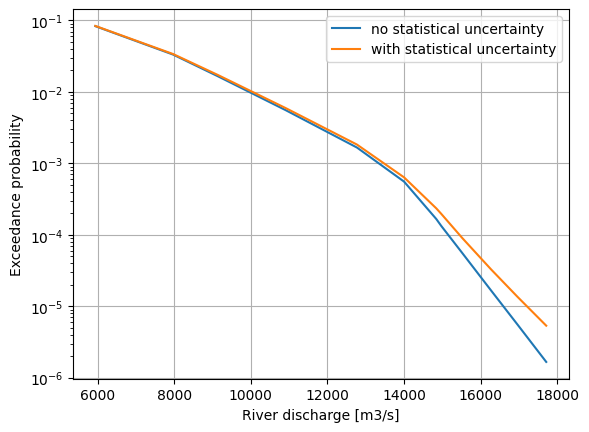

In [9]:
project.settings.reliability_method = ReliabilityMethod.form
Pf_with_stat_uncer = []

for w in Q_value:

    project.variables["w"].mean = w
    project.run()
    beta = project.design_point.reliability_index 
    Pf_with_stat_uncer.append(StandardNormal.get_q_from_u(beta))
    
plt.figure()
plt.semilogy(Q_value, Pf_no_stat_uncer, label="no statistical uncertainty")
plt.semilogy(Q_value, Pf_with_stat_uncer, label="with statistical uncertainty")
plt.xlabel("River discharge [m3/s]")
plt.ylabel("Exceedance probability")
plt.grid()
plt.legend()